# Comparison for LogSumExp

The LogSumExp-problem with linear consraints:
	$$\log(1 + \sum\limits_{k=1}^n \exp(\alpha x_k)) + \frac{\beta}{2} \|\textbf{x}\|_2^2 \rightarrow \min_{\textbf{x}\in \mathbb{R}^N}$$
	$$\text{s.t.} (\textbf{b}_j, \textbf{x}) - c_j <= 0, j = 1\dots M$$
	
This problem can be converted into saddle point problem:
	$$\min_{\textbf{x}} \max_{\textbf{y}\in\mathbb{R}^M_+} S(\textbf{x},\textbf{y}),$$
where $S(\textbf{x}, \textbf{y}) = r(\textbf{x})+F(\textbf{x}, \textbf{y}) - h(\textbf{y})$
	$$r(\textbf{x}) = \log(1 + \sum\limits_{k=1}^n \exp(\alpha x_k)) + \frac{\beta}{2} \|\textbf{x}\|_2^2$$
	$$F(\textbf{x}, \textbf{y}) = \sum\limits_{j=1}^M x_j(\textbf{b}_j, \textbf{y}) = (\textbf{x}, B\textbf{y})$$
	$$h(\textbf{y}) = (\textbf{c}, \textbf{y})$$

So N is dimensional of external variable, M - internal. But we will consider the external problem as help problem.

In [1]:
import numpy as np
from TestFunctions import LogSumExp_difalpha as LogSumExp
from TestFunctions.TestFunctions import TestFunction
from Solvers import GradientMethods
from Solvers.HalvCube import Dichotomy_exact
from Solvers.GradientMethods import FGM_internal
from Solvers.Ellipsoids import ellipsoid
import matplotlib.pyplot as plt
%matplotlib notebook
import comparison
import imp

from comparison import method_comparison, create_methods_dict

In [2]:
def get_LSE(N = 100, M = 2, alpha = 0.001, beta = 0.5e-3, k = 1, eps = 1e-3):
    """
    The function is to get class of LSE. All parameters mathes the
    parameters above.
    
    N is dimensional of primal problem
    M is number of constraints. It is also the dual dimension
    alpha is parameter of LogSumExp problem
    beta is coefficient of l2-regularization for primal problem
    
    k is parameter for to generate matrix B
    """
    alpha_ = np.random.uniform(size = (N,), low = -alpha, high = alpha)
    alpha = np.max(np.abs(alpha_))
    B = np.random.uniform(low = -k, high = 0, size = (M, N))
    c = np.ones((M,))
    x_ = np.zeros((N,))
    f_ = LogSumExp.r(alpha, beta).get_value(x_)
    gamma = c.max()
    y_max = f_/gamma
    Q = [[0, y_max] for i in range(M)]
    Q = np.array(Q)
    size_domain = np.linalg.norm(Q[:,0]-Q[:,1])
    solver = FGM_internal
    LSE_y_external = TestFunction(r = LogSumExp.h(c, size_domain = size_domain),
                    F = LogSumExp.F_tilde(B, size_domain),
                    h = LogSumExp.r(alpha_, beta, size_domain),
                    solver = solver, 
                    get_start_point = lambda x: (1/beta * -x.dot(B), alpha * np.sqrt(N)/beta))
    solver = ellipsoid
    LSE_ellipsoid = TestFunction(r = LogSumExp.r(alpha_, beta, size_domain),
                    F = LogSumExp.F(B, size_domain),
                    h = LogSumExp.h(c, beta = 0.001, size_domain = size_domain),
                    solver = solver, 
                    get_start_point = lambda x: ((Q[:,0] + Q[:, 1])/2, size_domain/4))
    solver = lambda func, grad, L, mu, start_point, cond: Dichotomy_exact().Halving(func, 
                                                                                    grad, 
                                                                                    L, mu, 
                                                                                    eps, 
                                                                                    start_point,
                                                                                    cond)
    LSE_dichotomy = TestFunction(r = LogSumExp.r(alpha_, beta, size_domain),
                F = LogSumExp.F(B, size_domain),
                h = LogSumExp.h(c, beta = 0.001, size_domain = size_domain),
                solver = solver, 
                get_start_point = lambda x: ((Q[:,0] + Q[:, 1])/2, size_domain/4))
    solver = FGM_internal
    LSE_fgm = TestFunction(r = LogSumExp.r(alpha_, beta, size_domain),
                F = LogSumExp.F(B, size_domain),
                h = LogSumExp.h(c, beta = 0.001, size_domain = size_domain),
                solver = solver, 
                get_start_point = lambda x: ((Q[:,0] + Q[:, 1])/2, size_domain/4))
    R = alpha * np.sqrt(N)/beta
    return (LSE_y_external, Q), (LSE_ellipsoid, R), (LSE_dichotomy, R), (LSE_fgm, R)

In [3]:
def start_comparison(N = 100, M = 2, alpha = 0.001, beta = 0.5e-3, k = 1, eps = 1e-3, time_max = 0.2):
    (LSE_y_external, Q), (LSE_ellipsoid, R), (LSE_dichotomy, R), (LSE_fgm, R) = get_LSE(N = N, M = M, alpha = alpha, beta = beta, k = k, eps = eps)
    keys = {"FGM":"y, x - FGM+FGM",
        "Ellipsoids": "y, x - Ellipsoids+FGM",
        "Dichotomy": "y, x - Dichotomy+FGM"}
    history = {}
    f_dict = {}
    
    methods = create_methods_dict(LSE_y_external, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = time_max, keys = keys)
    for key in methods:
        cond = lambda y, R: LSE_y_external.L_xx * R <= 1e-3
        f = lambda y: LSE_y_external.get_value(y, LSE_y_external.get_solution(y, cond)[0])
        f_dict[key] = f
    Q = np.vstack([np.zeros((N, )) - R * np.ones((N,)), np.zeros((N, )) + R * np.ones((N,))]).T
    
    methods["x, y - FGM+FGM"] = create_methods_dict(LSE_fgm, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = time_max, keys = {"FGM":"x, y - FGM+FGM"})["x, y - FGM+FGM"]
    cond = lambda y, R: LSE_fgm.L_xx * R <= eps
    f = lambda y: LSE_fgm.get_value(y, LSE_fgm.get_solution(y, cond)[0])
    f_dict["x, y - FGM+FGM"] = f

    methods["x, y - FGM+Ellipsoids"] = create_methods_dict(LSE_ellipsoid, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = time_max, keys = {"FGM":"x, y - FGM+Ellipsoids"})["x, y - FGM+Ellipsoids"]
    cond = lambda y, R: LSE_ellipsoid.L_yy * R <= eps
    f = lambda y: LSE_ellipsoid.get_value(y, LSE_ellipsoid.get_solution(y, cond)[0])
    f_dict["x, y - FGM+Ellipsoids"] = f

    methods["x, y - FGM+Dichotomy"] = create_methods_dict(LSE_dichotomy, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = time_max, keys = {"FGM":"x, y - FGM+Dichotomy"})["x, y - FGM+Dichotomy"]
    cond = lambda y, R: LSE_dichotomy.L_xx * R <= eps
    f = lambda y: LSE_dichotomy.get_value(y, LSE_dichotomy.get_solution(y, cond)[0])
    f_dict["x, y - FGM+Dichotomy"] = f
    
    comparison.method_comparison(methods)
    return history, f_dict

In [13]:
def get_plot(history, f, keys = None):
    if keys is None:
        keys = history.keys()
    values = []
    times = []
    for key in keys:
        t0 = history[key][0][1]
        times.append([i[1]-t0 for i in history[key]])
        u = [f_dict[key](i[0]) for i in history[key]]
        values.append(u)
    m = min([min(i) for i in values])
    m += (m-min([min([j for j in i if j != m]) for i in values]))
    for ind, t in enumerate(times):
        print(ind, len(times))
        print(values[ind]-m)
        plt.plot(t, values[ind]-m)
    plt.legend(keys)
    plt.grid()
    plt.yscale("log")
    plt.xlabel("Time, s")
    plt.ylabel("Values")
    return t, values

## M= 2

In [14]:
M = 2

### N = 100

In [15]:
N = 10

In [16]:
eps = 1e-4
history, f_dict = start_comparison(N = N, M = M, eps = eps, time_max = 10)
history.keys()
history = {key:history[key] for key in history if "x, y" in key and not "Dichotomy" in key}
history.keys()

dict_keys(['x, y - FGM+FGM', 'x, y - FGM+Ellipsoids'])

0 2
[9.99999903e+02 2.53616184e+02 7.87544772e+00 4.08019618e+00
 3.38024559e+00 2.86150992e+00 2.38633970e+00 1.95145432e+00
 1.56179438e+00 1.22078111e+00 9.29538844e-01 6.87094411e-01
 4.90745546e-01 3.36476093e-01 2.19376492e-01 1.34042510e-01
 7.49318668e-02 3.66644753e-02 1.42579008e-02 3.29519011e-03
 2.70651697e-05 1.41440941e-03 5.11984802e-03 9.45900935e-03
 1.33227939e-02 1.60817915e-02 1.74830465e-02 1.75478703e-02
 1.64775551e-02 1.45718458e-02 1.21630588e-02 9.56694627e-03
 7.04988796e-03 4.81082275e-03 2.97553268e-03 1.60045064e-03
 6.83047638e-04 1.76008163e-04 2.75520903e-06 7.23694213e-05
 2.92490939e-04 5.79337924e-04 8.64474320e-04 1.09837668e-03
 1.25116583e-03 1.31107650e-03 1.28134147e-03 1.17617872e-03
 1.01650979e-03 8.25926560e-04 6.27283558e-04 4.40144589e-04
 2.79172201e-04 1.53429005e-04 6.64690426e-05 1.70385085e-05
 1.77721054e-07 8.51663329e-06 3.35786062e-05 6.69448161e-05
 1.01177448e-04 1.30447259e-04 1.50854805e-04 1.60470687e-04
 1.59146233e-04 1.48

<IPython.core.display.Javascript object>


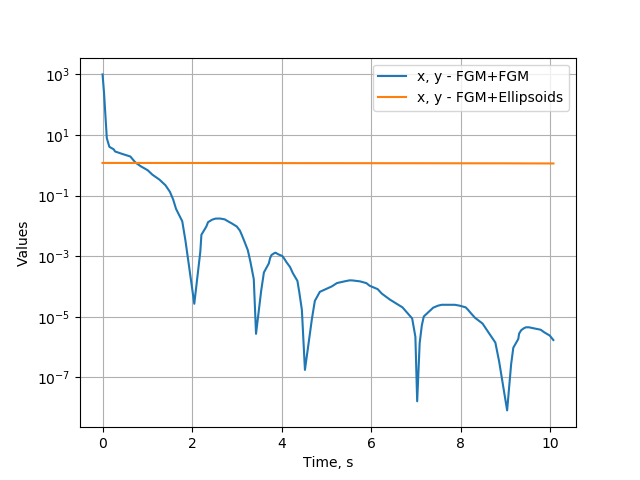

1 2
[1.1984774  1.19825723 1.19762741 1.19690444 1.19608839 1.19517913
 1.19417678 1.19308152 1.19189356 1.19061311 1.18924036 1.18777546
 1.18621859 1.18456987 1.18282944 1.18099742 1.17907392 1.17705903
 1.17495285 1.17275545 1.17046693 1.16808735 1.16561678 1.16305529
 1.16040294 1.15765978 1.15482586 1.15190125]


In [17]:
%matplotlib notebook
t, values = get_plot(history, f_dict)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [18]:
history

{'x, y - FGM+FGM': [(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
   1591836048.537175),
  (array([-0.0273029 , -0.10119601, -0.05162784, -0.07154272, -0.11761615,
          -0.10898649, -0.05172798, -0.10092257, -0.12355998, -0.12843007]),
   1591836048.618548),
  (array([-0.0528343 , -0.19028017, -0.09396938, -0.13257574, -0.22363184,
          -0.20235842, -0.09628538, -0.1918197 , -0.23249015, -0.24355192]),
   1591836048.6923103),
  (array([-0.05834829, -0.1990338 , -0.09188954, -0.13466267, -0.23902345,
          -0.2063711 , -0.09869663, -0.20487618, -0.24351265, -0.25900786]),
   1591836048.8147862),
  (array([-0.06219642, -0.20064565, -0.08562418, -0.13136096, -0.24654643,
          -0.20224388, -0.0972864 , -0.21116839, -0.24584275, -0.26575988]),
   1591836049.0097506),
  (array([-0.06574689, -0.20081615, -0.07843404, -0.12692157, -0.25254519,
          -0.19640764, -0.09507969, -0.21614835, -0.24642265, -0.27080844]),
   1591836049.1515381),
  (array([-0.06920275, -0.20

In [ ]:
eps = 1e-6

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [ ]:
eps = 1e-9

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

### N = 1000

In [ ]:
N = 1000

In [ ]:
eps = 1e-3

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [ ]:
eps = 1e-6

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [ ]:
eps = 1e-9

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

## M= 3

In [ ]:
M = 3

### N = 100

In [ ]:
N = 100

In [ ]:
eps = 1e-6

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [ ]:
eps = 1e-12

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [ ]:
eps = 1e-18

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

### N = 1000

In [ ]:
N = 1000

In [ ]:
eps = 1e-6

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.2)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [ ]:
eps = 1e-12

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.3)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)

In [ ]:
eps = 1e-18

LSE, Q = get_LSE(N, M)
history = {}
methods = create_methods_dict(LSE, np.mean(Q, axis = 1),
                              np.linalg.norm(Q[:,0]-Q[:,1]),
                              Q, eps, history, time_max = 0.3)
comparison.method_comparison(methods)

In [ ]:
%matplotlib notebook
cond = lambda y, R: LSE.L_xx * R <= 1e-3
f = lambda y: LSE.get_value(y, LSE.get_solution(y, cond)[0])
#f = lambda y: LSE.h.get_value(LSE.get_solution(y, cond)[0])
t, values = get_plot(history, f)
name_fig = str(M)+"_" + str(N) + "_" + str(eps) + ".png"
plt.savefig("Images/" + name_fig)